In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import tensorflow
from tensorflow import keras
from keras.datasets import cifar10
(trainx, trainy) , (testx, testy) = cifar10.load_data()

(-0.5, 31.5, 31.5, -0.5)

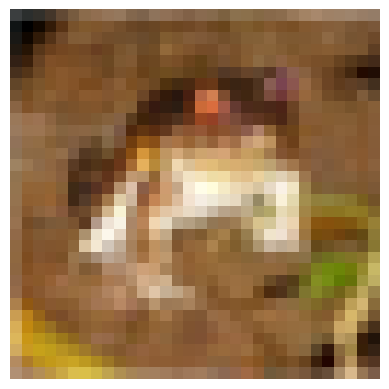

In [31]:
plt.imshow(trainx[0])
plt.axis('off')

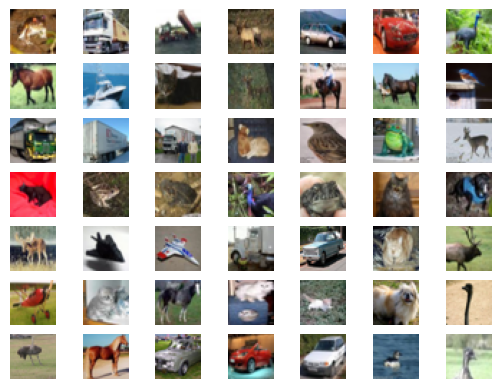

In [32]:
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(trainx[i])
plt.show()

In [33]:
print(trainx.shape)
print(trainx[0].shape)

(50000, 32, 32, 3)
(32, 32, 3)


In [34]:
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils import plot_model


In [35]:
def descriminator(in_shape = (32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape = in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3),strides=(2,2) , padding='same'))            ## using strides for downsampling to reduce the size
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3),strides=(2,2) , padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3),strides=(2,2) , padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr = 0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

    return model


In [36]:
model = descriminator()
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 4, 4, 256)        

### For Real Images

In [37]:
def load_realsamples():
    (trainx,_) , (_,_) = cifar10.load_data()
    X = trainx.astype('float32')
    X = (X-127.5)/127.5
    return X

In [38]:
X = load_realsamples()
X[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

In [39]:
X.shape

(50000, 32, 32, 3)

In [40]:
### Fi=unction that takes the images in batch and jsut give them to the discriminator
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples )
    X = dataset[ix]
    y = np.ones((n_samples,1))
    return X,y

In [41]:
X,y = generate_real_samples(X,64)
print(X.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [42]:
### function that generates fake samples and labeled as a 0 
def generate_fake_samples(n_samples):
    X = np.random.rand(32*32*3*n_samples)
    X = -1 + X * 2
    X = X.reshape(n_samples,32,32,3)        ## just reshaping so that same as in input dimension
    y = np.zeros((n_samples,1))
    return X,y


(-0.5, 31.5, 31.5, -0.5)

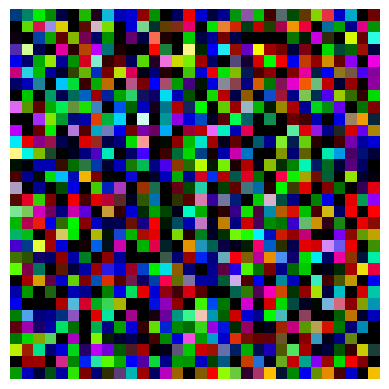

In [43]:
X,y = generate_fake_samples(64)
plt.imshow(X[0])
plt.axis('off')


In [44]:
### we are updating weight 2 times in one iteration of the loop because one time it takes the real data and then upate the weights and 
## fake data and updating weiights 

def train_discriminator(model, dataset, epochs = 20, batch_size = 128):
    half_batch = int(batch_size/2)
    for i in range(epochs):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _ , real_acc = model.train_on_batch(X_real, y_real)         ### real accuracy

        X_fake, y_fake = generate_fake_samples(half_batch)
        _ , fake_acc = model.train_on_batch(X_fake, y_fake)         ### fake accuracy

        print(i+1, real_acc*100, fake_acc*100)

In [45]:
### training example
model = descriminator()     # calling discriminator as model
dataset = load_realsamples()    ### dataset providing
train_discriminator(model, dataset)         ### training


1 40.625 0.0
2 98.4375 0.0
3 100.0 25.0
4 100.0 98.4375
5 100.0 100.0
6 96.875 100.0
7 100.0 100.0
8 100.0 100.0
9 100.0 100.0
10 100.0 100.0
11 100.0 100.0
12 100.0 100.0
13 100.0 100.0
14 100.0 100.0
15 100.0 100.0
16 100.0 100.0
17 100.0 100.0
18 100.0 100.0
19 100.0 100.0
20 100.0 100.0


In [46]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose
from keras.utils import plot_model


In [47]:
def generator(latent_variable):         ### latent variable is noise in our case it is 100 dimensional vector
    model = Sequential()

    n_nodes = 256*4*4           ### 4x4 image but we have to upsample using transposeconc2d
    model.add(Dense(n_nodes, input_dim = latent_variable))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))
    ### here strides 2x2 updamples the image and 8x8
    model.add(Conv2DTranspose(128 , (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    ### after strides and upsampling 16x16
    model.add(Conv2DTranspose(128 , (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    ### upsampling 32x32
    model.add(Conv2DTranspose(128 , (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3 , (3,3), padding='same', activation='tanh'))
    return model


In [48]:
latent_variable = 100
model = generator(latent_variable)
model.summary()
plot_model(model, to_file="genrator.png", show_shapes=True, show_layer_names=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 8, 8, 128)         524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                          

In [49]:
### function to genrate images of the batch size that is required by the discriminator like if 128 then 64 will be the real
#### and 64  will be the fake imakes
def generate_latent_points(latent_variable, n_samples):
    x_input = np.random.randn(latent_variable,n_samples)    ### latent_variable is rows and n_sample mean columns
    x_input = x_input.reshape(n_samples,latent_variable)
    return x_input

In [50]:
X_input = generate_latent_points(100, 64)
print(X_input.shape)  ## as input it will take 64 100 dim vectors and outputs 64 images that will be fake and this is done by the generator

(64, 100)


In [51]:
def generate_fake_samples(g_model, latent_variable,n_samples):
    X_input = generate_latent_points(latent_variable, n_samples)
    X = g_model.predict(X_input)
    y = np.zeros((n_samples,1))
    return X,y

2/2 [==============================] - 0s 114ms/step


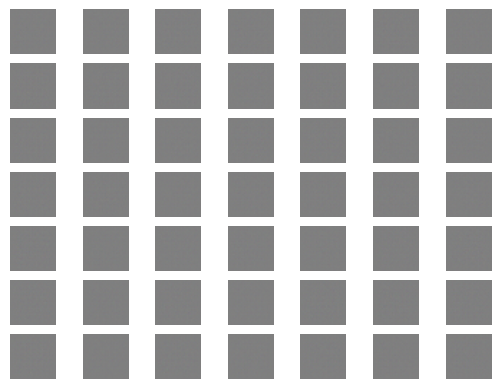

In [52]:
latent_variable = 100
model = generator(latent_variable)
n_samples = 49
X, _ = generate_fake_samples(model, latent_variable, n_samples)
X = (X+1) / 2
for i in range(n_samples):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(X[i])

plt.show()


In [53]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr = 0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [54]:
latent_variable = 100
d_model = descriminator()
g_model = generator(latent_variable)
gan_model = define_gan(g_model, d_model)
gan_model.summary()



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


In [56]:
def train(g_model, d_model, gan_model, latent_variable = 100, n_epochs =200, n_batch = 128):
    batch_per_epoch = int((dataset.shape[0])/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real , y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_variable, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_variable, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            


In [59]:
def summary(epochs, g_model,d_model, dataset,latent_variable, n_samples=150):
    X_real , y_real = generate_real_samples(dataset, n_samples)
    _ , real_acc = d_model.evaluate(X_real , y_real, verbose=0)

    X_fake, y_fake = generate_fake_samples(g_model, latent_variable, n_samples)
    _ , fake_acc = d_model.evaluate(X_fake, y_fake ,verbose=0)

    print("Accuracy = ", real_acc*100, fake_acc*100)
